# Filesystem ML Analysis
### Nathan Tibbetts
### Winter 2020
### ACME Vol 3

## Init and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

import statsmodels.api as sm

In [2]:
# Read in our data file, show its columns
data = pd.read_pickle("data0_ML.pkl")
data['Is Link'] = data['Is Link To'] > -1
data['Days Since Modified'] = np.array([dt.days for dt in data['Modification Recency']])
print(data.columns)

# Data split for Regression-type algorithms
#   We do 708,684 train / 100,000 validate / 200,000 test
X = data[['User Read',  'User Write',  'User Execute',
          'Group Read', 'Group Write', 'Group Execute',
          'Other Read', 'Other Write', 'Other Execute',
          'Belongs to Root', 'Sticky',
          'Is Directory', 'Is Regular File', 'Is Link',
          'Sub-Desktop', 'Sub-Desktop-Parent',
          'Hidden', 'Sub-Hidden',
          'Child Count', 'Depth',
          'Days Since Modified',
          'Size Log2']].astype(np.float32)
XI  = data['Importance'].astype(np.float32)
YRW = data['Recursive Weight'].astype(np.float32)
YRI = data['Recursive Importance'].astype(np.float32)
X_train, X_validate, XI_train, XI_validate, YRW_train, YRW_validate, YRI_train, YRI_validate \
    = train_test_split(X, XI, YRW, YRI, test_size=300000)
X_validate, X_test, XI_validate, XI_test, YRW_validate, YRW_test, YRI_validate, YRI_test \
    = train_test_split(X_validate, XI_validate, YRW_validate, YRI_validate, test_size=200000)

Index(['Parent', 'Size', 'Hidden', 'Sub-Hidden', 'Sticky', 'User Read',
       'User Write', 'User Execute', 'Group Read', 'Group Write',
       'Group Execute', 'Other Read', 'Other Write', 'Other Execute',
       'Is Directory', 'Is Regular File', 'Is Link To', 'Desktop',
       'Sub-Desktop', 'Sub-Desktop-Parent', 'Path', 'Irregular', 'Userspace',
       'Modification Recency', 'Child Count', 'Depth', 'Size Log2',
       'Importance', 'Belongs to Root', 'Recursive Weight',
       'Recursive Importance', 'Is Link', 'Days Since Modified'],
      dtype='object')


## FF Neural Network

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Presets
n = X_train.shape[1]

# FF Model
class FF_Model(nn.Module):
    ''' A simple feed forward network model for regression '''
    def __init__(self):
        super(FF_Model, self).__init__()

        self.relu    = nn.ReLU()
        self.linear1 = nn.Linear(n, 100)  # 1x100
        self.linear2 = nn.Linear(100, 100) # 1x100
        self.linear3 = nn.Linear(100, 100) # 1x100
        self.linear4 = nn.Linear(100, 100) # 1x100
        self.linear5 = nn.Linear(100, 1)  # 1x1
        self.flat    = nn.Flatten()

    def forward(self, x):
        out = self.relu(self.linear1(x))   # 1x100
        out = self.relu(self.linear2(out)) # 1x100
        out = self.relu(self.linear3(out)) # 1x100
        out = self.relu(self.linear4(out)) # 1x100
        out = self.linear5(out) # 1x1
        return self.flat(out)

In [51]:
# Test the model
model = FF_Model().to(device)

print("Parameters:", np.sum([np.prod(p.size()) for p in model.parameters()]))

m = model(torch.tensor(X_train.values)[0].unsqueeze(0).to(device))
print(m)

Parameters: 32701
tensor([[0.1585]], grad_fn=<AddmmBackward>)


In [52]:
# Init
model     = FF_Model().to(device)
log_model = FF_Model().to(device)
B = 100 # Batch Size
T = len(X_train) // B
losses     = []
log_losses = []
loop = tqdm(total=T, position=0)

# Convert types and move to GPU if available
X1  = torch.tensor(X_train.values).to(device)
Y1  = torch.tensor(YRW_train.values).to(device)
Y1B = torch.tensor(np.log(YRW_train.values)).to(device) # Attempting logarithm of answers

# Define our optimization scheme
objective = nn.L1Loss()
optimizer = optim.Adam(model.parameters())
log_optimizer = optim.Adam(log_model.parameters())

# Train
for i in range(T):
    # Slice to get a batch
    x  = X1[B*i:B*(i+1)]  # Data
    y  = Y1[B*i:B*(i+1)]  # Labels (Truth)
    ly = Y1B[B*i:B*(i+1)] # Log labels
    # Optimize
    optimizer.zero_grad()               # Zero out the gradients
    log_optimizer.zero_grad()
    outputs = model(x)                  # Run the model
    log_outputs = log_model(x)
    loss = objective(outputs, y)        # Calculate the loss
    log_loss = objective(log_outputs, ly)
    losses.append(loss.item())          # Save the loss for later
    log_losses.append(log_loss.item())
    loss.backward()                     # Backpropogate the error
    log_loss.backward()
    optimizer.step()                    # Optimize
    log_optimizer.step()
    loop.set_description('Loss: {:.4f}'.format(loss.item()))
    loop.update(1)

  0%|          | 0/7086 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:88: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
Loss: 0.1217: 100%|█████████▉| 7085/7086 [01:04<00:00, 106.49it/s] 

$\mu_i: 1.3373373
Avg |W_i-\mu_i|: 0.6220867
Loss: 0.35268550428581646
e^Loss on log(y): 1.0855151423949971
Accuracy: 0.43306053297022984


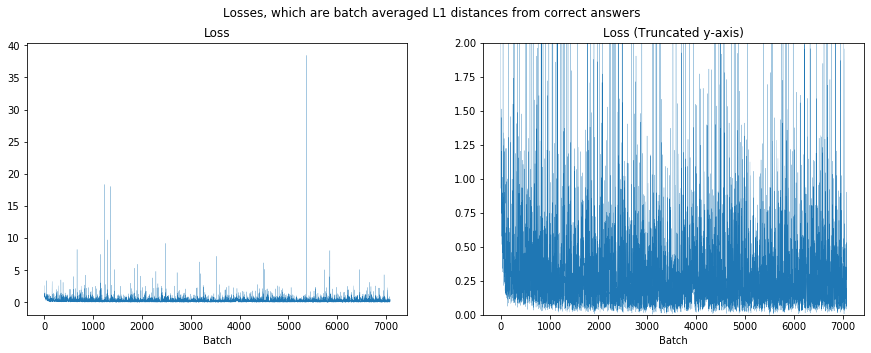

In [54]:
# Print average loss
mu = np.mean(YRW_train.values)
avg_dist = np.mean(np.abs(YRW_train.values-mu))
l = np.mean(losses)
print(r"$\mu_i:", mu)
print(r"Avg |W_i-\mu_i|:", avg_dist)
print("Loss:", l)
print("e^Loss on log(y):", np.mean(np.exp(log_losses)))
print("Accuracy:", (avg_dist-l)/avg_dist)

# Plots
plt.figure(figsize=(15,5))
plt.suptitle("Losses, which are batch averaged L1 distances from correct answers")

# Plot Loss
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(losses, lw=.2)
plt.xlabel("Batch")

# Plot same but truncated
plt.subplot(1,2,2)
plt.title("Loss (Truncated y-axis)")
plt.plot(losses, lw=.2)
plt.xlabel("Batch")
plt.ylim(0, 2)

# # Plot log loss
# plt.subplot(2,2,3)
# plt.title("Loss trained on log(y)")
# plt.plot(log_losses, lw=.2)
# plt.xlabel("Batch")

# # Plot the exp of log loss
# plt.subplot(2,2,4)
# plt.title("$e^{Loss}$ trained on log(y)")
# plt.plot(np.exp(log_losses), lw=.2)
# plt.xlabel("Batch")

plt.show()

In [182]:
# Recompute average loss on training data after training has been completed
X2 = torch.tensor(X_train.values).to(device)

# Validate
model.eval() # Set model to evaluation mode
outputs = model(X2) # Run the model
out  = np.ravel(outputs.detach().numpy())
dist = np.abs(out - YRW_train.ravel())
model.train() # Set model back to training mode

# Print average distance from correct answers
print("Average L1 Dist on train:", np.mean(dist))

# Recompute average loss on test data after training has been completed
X3 = torch.tensor(X_test.values).to(device)

# Validate
model.eval() # Set model to evaluation mode
outputs = model(X3) # Run the model
out  = np.ravel(outputs.detach().numpy())
dist2 = np.abs(out - YRW_test.ravel())
model.train() # Set model back to training mode

# Print average distance from correct answers
print("Average L1 Dist on test:", np.mean(dist2))
mu = np.mean(YRW.values)
avg_dist = np.mean(np.abs(YRW.values-mu))
print(mu, avg_dist, (avg_dist-np.mean(dist2))/avg_dist)

Average L1 Dist on train: 0.33279213
Average L1 Dist on test: 0.3579775
1.3330874 0.6142719 0.41723278


Clearly, L1 loss didn't go so well. It simply learned an approximation that gets a high accuracy and has no respect for the outliers - which are rather important in our dataset. So let's focus on trying to see the accuracy on our validation set - a conversion of our log loss, if you will.

Average L1 Dist: 0.35824153


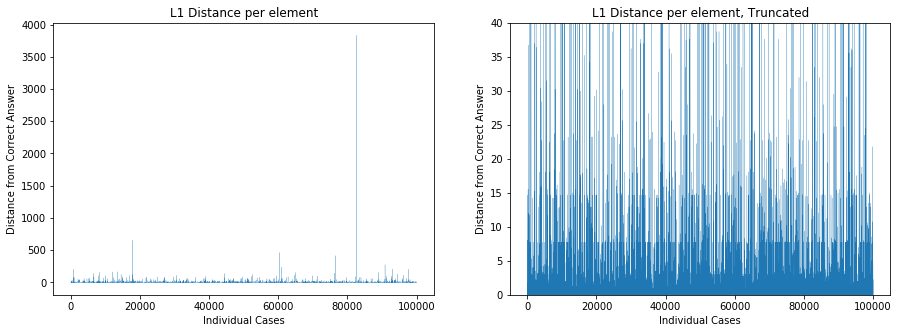

In [9]:
# Convert types and move to GPU if available
X2  = torch.tensor(X_validate.values).to(device)
# Y2  = torch.tensor(YRW_validate.values).to(device)

# Validate
log_model.eval() # Set model to evaluation mode
outputs = log_model(X2) # Run the model
out  = outputs.detach().numpy()
out  = np.exp(np.ravel(out)) # Exponentiate to reflect real life answers
dist = np.abs(out - YRW_validate.ravel())
log_model.train() # Set model back to training mode

# Print average distance from correct answers
print("Average L1 Dist:", np.mean(dist))

# Plot it
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("L1 Distance per element")
plt.plot(dist, lw=.2)
plt.xlabel("Individual Cases")
plt.ylabel("Distance from Correct Answer")

plt.subplot(1,2,2)
plt.title("L1 Distance per element, Truncated")
plt.plot(dist, lw=.2)
plt.xlabel("Individual Cases")
plt.ylabel("Distance from Correct Answer")
plt.ylim(0, 40)

plt.show()

Now obviously that didn't work one bit. Now, the answers look worse, but we're just not batch averaging them here, so they're probably about the same.

Now we try slimming down the data to have a more even split among a few stratifications of our data.

In [5]:
print(len(data[(data['Recursive Weight'] < 4) & (data['Recursive Weight'] > 1)]))

65546


In [5]:
data_slim = pd.concat((
    data[data['Recursive Weight'] > 15],
    data[(data['Recursive Weight'] < 4) & (data['Recursive Weight'] > 1)][:6000],
    data[(data['Recursive Weight'] >= 4) & (data['Recursive Weight'] <= 15)][:6000]))

# Data split for Regression-type algorithms
#   We do 14130 train / 3000 test
X_slim = data_slim[[
    'User Read',  'User Write',  'User Execute',
    'Group Read', 'Group Write', 'Group Execute',
    'Other Read', 'Other Write', 'Other Execute',
    'Belongs to Root', 'Sticky',
    'Sub-Desktop', 'Sub-Desktop-Parent',
    'Hidden', 'Sub-Hidden',
    'Child Count', 'Depth',
    'Days Since Modified']].astype(np.float32)
XI_slim  = data_slim['Importance'].astype(np.float32)
YRW_slim = data_slim['Recursive Weight'].astype(np.float32)
YRI_slim = data_slim['Recursive Importance'].astype(np.float32)

# The test train split shuffles things for us
X_train_slim, X_test_slim, XI_train_slim, XI_test_slim, YRW_train_slim, YRW_test_slim, YRI_train_slim, YRI_test_slim \
    = train_test_split(X_slim, XI_slim, YRW_slim, YRI_slim, test_size=3000)

In [174]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
# Test the model
n = X_train_slim.shape[1]
model_slim = FF_Model().to(device)

print("Parameters:", np.sum([np.prod(p.size()) for p in model_slim.parameters()]))

m = model_slim(torch.tensor(X_train_slim.values)[0].unsqueeze(0).to(device))
print(m)

Parameters: 12101
tensor([[-0.0363]], grad_fn=<AddmmBackward>)


In [14]:
# Init
B_slim = 20 # Batch Size
T_slim = len(X_train_slim) // B_slim
E = 40 # Max epochs
losses_slim = []
loop = tqdm(total=T_slim*E, position=0)

# Convert types and move to GPU if available
X1_slim  = torch.tensor(X_train_slim.values).to(device)
Y1_slim  = torch.tensor(YRW_train_slim.values).to(device)

# Define our optimization scheme
# objective = nn.L1Loss()
optimizer = optim.Adam(model_slim.parameters())

# Train
for epoch in range(E):
    for i in range(T_slim):
        # Slice to get a batch
        x  = X1_slim[B_slim*i:B_slim*(i+1)]  # Data
        y  = Y1_slim[B_slim*i:B_slim*(i+1)]  # Labels (Truth)
        #x = X1_slim[0:B_slim] # FOR OVERFIT TEST
        #y = Y1_slim[0:B_slim] # FOR OVERFIT TEST
        # Optimize
        optimizer.zero_grad()               # Zero out the gradients
        outputs = model_slim(x)                  # Run the model
        #loss = objective(torch.flatten(outputs), y)        # Calculate the loss
        loss = torch.mean(torch.abs(outputs-y))
        losses_slim.append(loss.item())          # Save the loss for later
        loss.backward()                     # Backpropogate the error
        optimizer.step()                    # Optimize
        loop.set_description('Loss: {:.4f}'.format(loss.item()))
        loop.update(1)

Loss: 197.5914: 100%|█████████▉| 28239/28240 [02:21<00:00, 202.47it/s]

In [175]:
# Recompute average loss on training data after training has been completed
X2 = torch.tensor(X_train_slim.values).to(device)

# Validate
model_slim.eval() # Set model to evaluation mode
outputs = model_slim(X2) # Run the model
out  = np.ravel(outputs.detach().numpy())
dist = np.abs(out - YRW_train_slim.ravel())
model_slim.train() # Set model back to training mode

# Print average distance from correct answers
print("Average L1 Dist:", np.mean(dist))

Average L1 Dist: 11.752026


In [178]:
# Recompute average loss on training data after training has been completed
X3 = torch.tensor(X_test_slim.values).to(device)

# Validate
model_slim.eval() # Set model to evaluation mode
outputs = model_slim(X3) # Run the model
out  = np.ravel(outputs.detach().numpy())
dist = np.abs(out - YRW_test_slim.ravel())
model_slim.train() # Set model back to training mode

# Print average distance from correct answers
print("Average L1 Dist:", np.mean(dist))
mu = np.mean(YRW_slim.values)
avg_dist = np.mean(np.abs(YRW_slim.values-mu))
print(mu, avg_dist, (avg_dist-np.mean(dist))/avg_dist)

Average L1 Dist: 11.496799
15.407291 14.864438 0.22655673


$\mu_i:$ 15.5558605
Avg $|W_i-\mu_i|$: 15.021822
Loss on slim data: 12.517235514580697
Accuracy: 0.16672987239347603


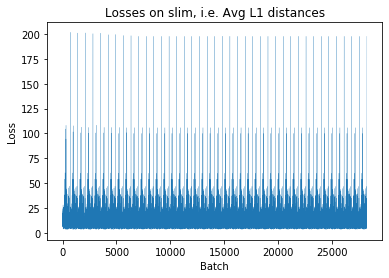

In [32]:
# Print average loss
mu_slim = np.mean(YRW_train_slim.values)
l = np.mean(losses_slim)
avg_dist = np.mean(np.abs(YRW_train_slim.values-mu_slim))
print(r"$\mu_i:$", mu_slim)
print(r"Avg $|W_i-\mu_i|$:", avg_dist)
print("Loss on slim data:", l)
print("Accuracy:", (avg_dist-l)/avg_dist)

# Plots
plt.title("Losses on slim, i.e. Avg L1 distances")
plt.ylabel("Loss")
plt.plot(losses_slim, lw=.2)
plt.xlabel("Batch")

plt.show()

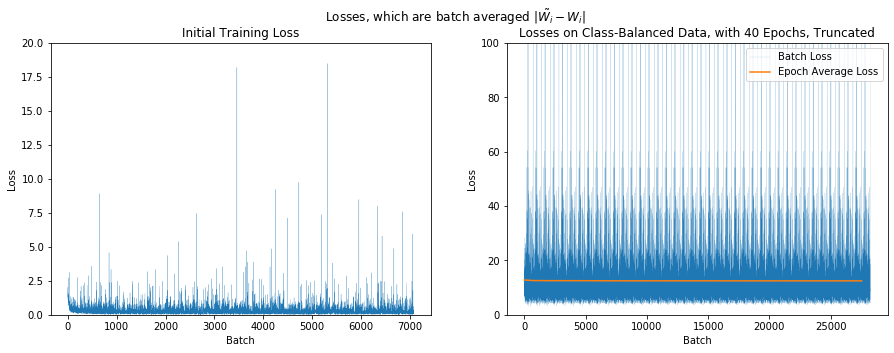

In [30]:
# Compute epoch average for losses on slim
l = int(len(losses_slim)/E)
avg_losses_slim = [np.mean(losses_slim[i*l:(i+1)*l]) for i in range(40)]

# Plots
plt.figure(figsize=(15,5))
plt.suptitle(r"Losses, which are batch averaged $|\tilde{W_i}-W_i|$")

# Plot Loss
plt.subplot(1,2,1)
plt.title("Initial Training Loss")
plt.plot(losses, lw=.2)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.ylim((0, 20))

# Plots
plt.subplot(1,2,2)
plt.title("Losses on Class-Balanced Data, with 40 Epochs, Truncated")
plt.ylabel("Loss")
plt.plot(losses_slim, lw=.1, label="Batch Loss")
plt.plot(range(0,len(losses_slim),l), avg_losses_slim, label="Epoch Average Loss")
plt.xlabel("Batch")
plt.legend()
plt.ylim((0, 100))

plt.savefig("losses.pdf",bbox_inches="tight")
plt.show()

The data appears to be so random that it's hard even to overfit it unless we use a tiny amount of data. Awkward. It appears there is no pattern at all for it to learn. That's good to know - but this is unsurprising.

## Google USE and UMAP

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
import umap
import umap.plot as uplt
import pickle
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mc

In [37]:
# Make a dataset of "sentences" from the paths, with spaces in place of slashes, and no other changes
strings = np.array([s.replace("/", " ") for s in data_slim.Path.values])

In [7]:
# # Embed the sentences as vectors
# embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# embeddings = embed(strings)

# print(embeddings)

tf.Tensor(
[[-0.03565681 -0.03319571  0.07047429 ... -0.0636081  -0.02079297
  -0.02250966]
 [-0.00857493 -0.01539204  0.0538075  ... -0.03719108  0.01801893
   0.00662172]
 [ 0.01830695 -0.03915352 -0.0078949  ... -0.04962797  0.09372752
   0.01656475]
 ...
 [ 0.037072    0.01894823 -0.08547873 ...  0.08511574 -0.06639438
  -0.0149194 ]
 [ 0.04343219  0.01810085 -0.08835329 ...  0.08396022 -0.06269484
  -0.02486012]
 [ 0.03949121  0.01920594 -0.08716708 ...  0.07813439 -0.06354128
  -0.0342127 ]], shape=(17130, 512), dtype=float32)


In [25]:
# with open("embeddings_slim.pkl", "wb") as f:
#     pickle.dump(embeddings.numpy(), f)

In [39]:
# Load pickled embeddings
with open("embeddings_slim.pkl", "rb") as f:
    embeddings = pickle.load(f)
print(embeddings.shape)

(17130, 512)


In [7]:
# # Test/Train split
# embed_train, embed_test, orig_train, orig_test, RW_train, RW_test, ds_train, ds_test \
#     = train_test_split(embeddings, X_slim, YRW_slim, data_slim, test_size=3000)
orig_train, orig_test, RW_train, RW_test, ds_train, ds_test \
    = train_test_split(X_slim, YRW_slim, data_slim, test_size=3000)

In [8]:
# From experience with various hyperparameters, we choose this specific mapping:
reducer2 = umap.UMAP(n_neighbors=10, min_dist=.5, n_components=2, metric='euclidean', random_state=43)
reducer3 = umap.UMAP(n_neighbors=35, min_dist=.5, n_components=3, metric='euclidean', random_state=43)
# embed_train2 = reducer2.fit_transform(embed_train)
# embed_train3 = reducer3.fit_transform(embed_train)
orig_train2 = reducer2.fit_transform(orig_train)
orig_train3 = reducer3.fit_transform(orig_train)
# embed_test2 = reducer2.transform(embed_test)
# embed_test3 = reducer3.transform(embed_test)
orig_test2 = reducer2.transform(orig_test)
orig_test3 = reducer3.transform(orig_test)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [9]:
# UMAP projection wrapper function
def draw_umap(x, colors='b', legend=None, title='', cmap='viridis_r', fig_size=1, alpha=1, s=.5):
    fig = plt.figure(figsize=(7.5*fig_size,5*fig_size))
    if len(x[0]) == 2:
        ax = fig.add_subplot(111)
        m = ax.scatter(x[:,0], x[:,1], c=colors, alpha=alpha, s=s, cmap=cmap)
    elif len(x[0]) == 3:
        ax = fig.add_subplot(111, projection='3d')
        m = ax.scatter(x[:,0], x[:,1], x[:,2], c=colors, alpha=alpha, s=s, cmap=cmap)
    else:
        raise ValueError()
    if legend is not None:
        ax.legend(handles=legend)
    else:
        plt.colorbar(m).solids.set(alpha=1)
    plt.title(title)
    plt.show()

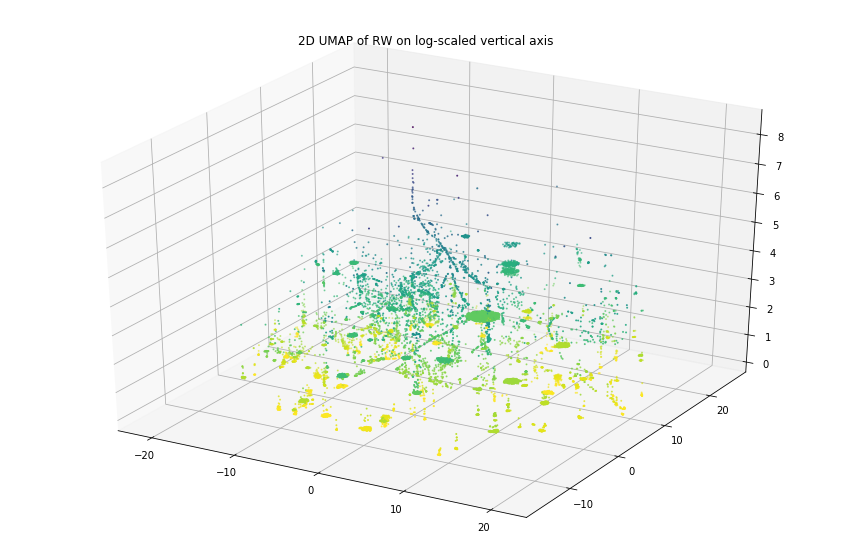

In [14]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
m = ax.scatter(*orig_train2.T, np.log(RW_train), c=RW_train, s=1, cmap='viridis_r', norm=mc.LogNorm())
plt.title("2D UMAP of RW on log-scaled vertical axis")
plt.show()

The above graph shows cluster diffusion.

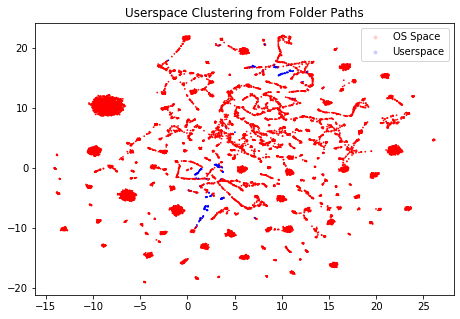

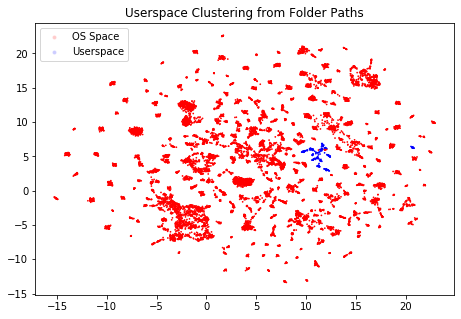

In [86]:
# Define color classes
colors = ['b' if v else 'r' for v in ds_train.Userspace.values]
legend = [
    Line2D([0], [0], marker='o', color='w', alpha=.2, label='OS Space', markerfacecolor='r', markersize=4),
    Line2D([0], [0], marker='o', color='w', alpha=.2, label='Userspace', markerfacecolor='b', markersize=4)]
# UMAP for Userspace vs. OS Space
draw_umap(orig_train2, colors, legend, title="Userspace Clustering from Folder Paths")
draw_umap(embed_train2, colors, legend, title="Userspace Clustering from Folder Paths")

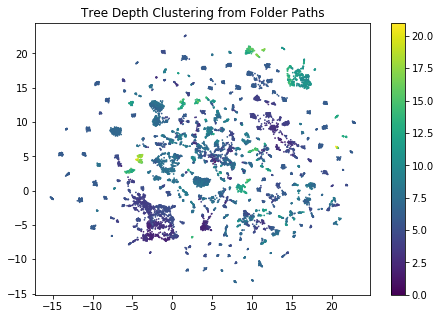

In [103]:
# UMAP for Tree Depth
draw_umap(embed_train2, ds_train.Depth.values, None, title="Tree Depth Clustering from Folder Paths", cmap="viridis")

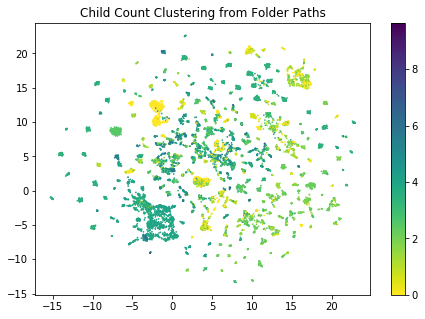

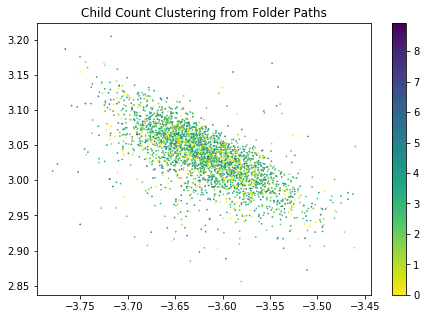

In [105]:
# UMAP for Child Count
draw_umap(embed_train2, np.log(ds_train['Child Count'].values), None, title="Child Count Clustering from Folder Paths")
draw_umap(embed_test2, np.log(ds_test['Child Count'].values), None, title="Child Count Clustering from Folder Paths")

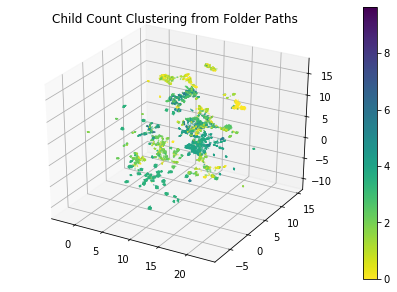

In [106]:
# UMAP for Child Count
draw_umap(embed_train3, np.log(ds_train['Child Count'].values), None, title="Child Count Clustering from Folder Paths", s=.1)

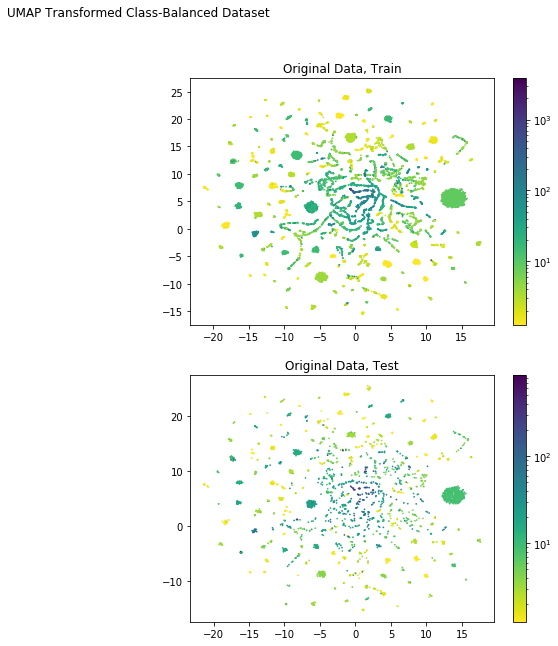

In [13]:
# UMAP, colored by log(RW)
plt.figure(figsize=(15,10))
plt.suptitle("UMAP Transformed Class-Balanced Dataset")

# plt.subplot(221)
# plt.title("Encoded Path Vectors, Train")
# plt.scatter(*embed_train2.T, c=RW_train.values, s=.5, cmap='viridis_r', norm=mc.LogNorm())

plt.subplot(222)
plt.title("Original Data, Train")
plt.scatter(*orig_train2.T, c=RW_train.values, s=.5, cmap='viridis_r', norm=mc.LogNorm())
plt.colorbar()

# plt.subplot(223)
# plt.title("Encoded Path Vectors, Test")
# plt.scatter(*embed_test2.T, c=RW_test.values, s=.5, cmap='viridis_r', norm=mc.LogNorm())

plt.subplot(224)
plt.title("Original Data, Test")
plt.scatter(*orig_test2.T, c=RW_test.values, s=.5, cmap='viridis_r', norm=mc.LogNorm())
plt.colorbar()

plt.savefig("clusters.pdf",bbox_inches="tight")
plt.show()

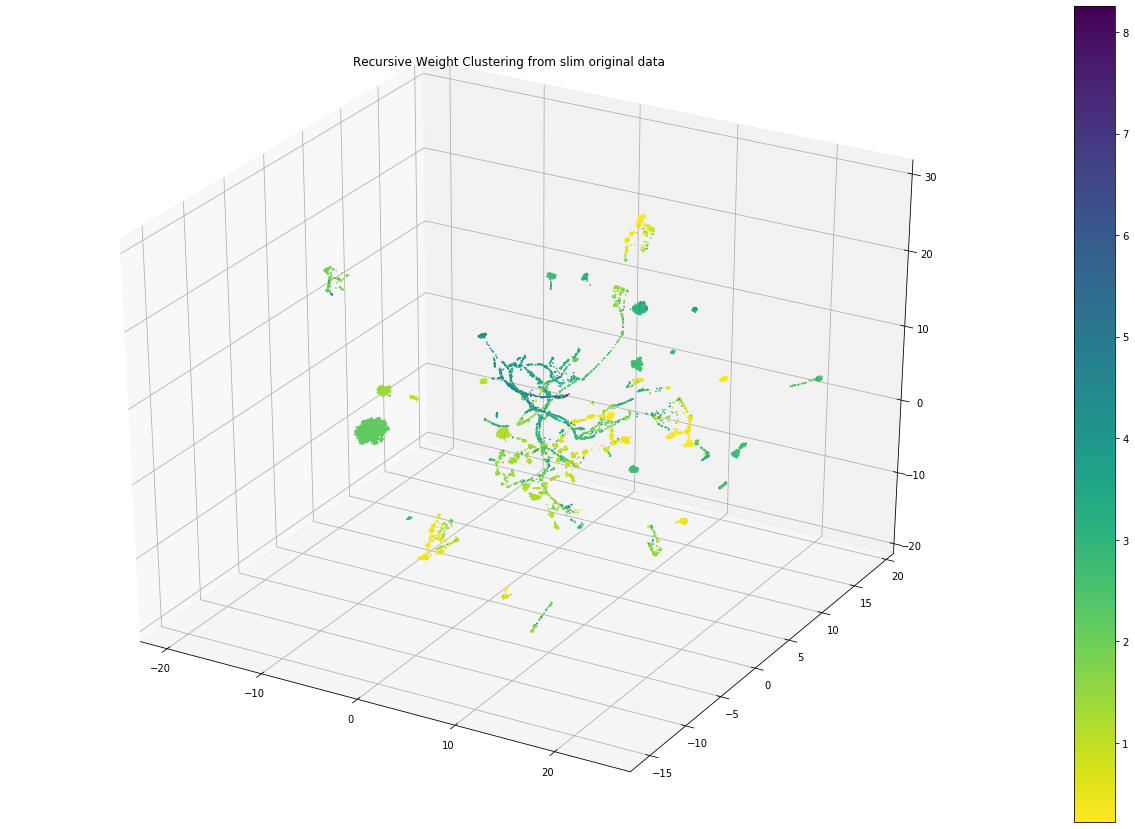

In [14]:
# UMAP on original data
draw_umap(orig_train3, np.log(ds_train['Recursive Weight'].values), None, title="Recursive Weight Clustering from slim original data", fig_size=3)

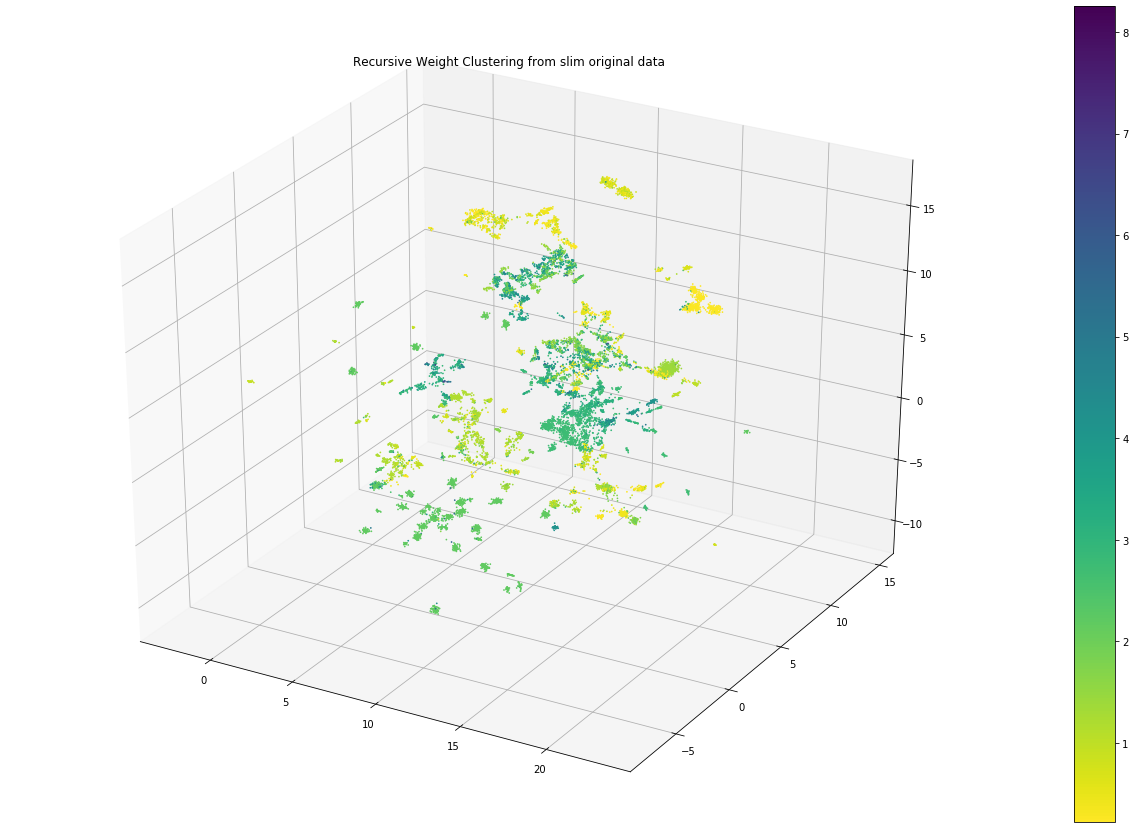

In [108]:
# UMAP on original data
draw_umap(embed_train3, np.log(ds_train['Recursive Weight'].values), None, title="Recursive Weight Clustering from slim original data", fig_size=3)

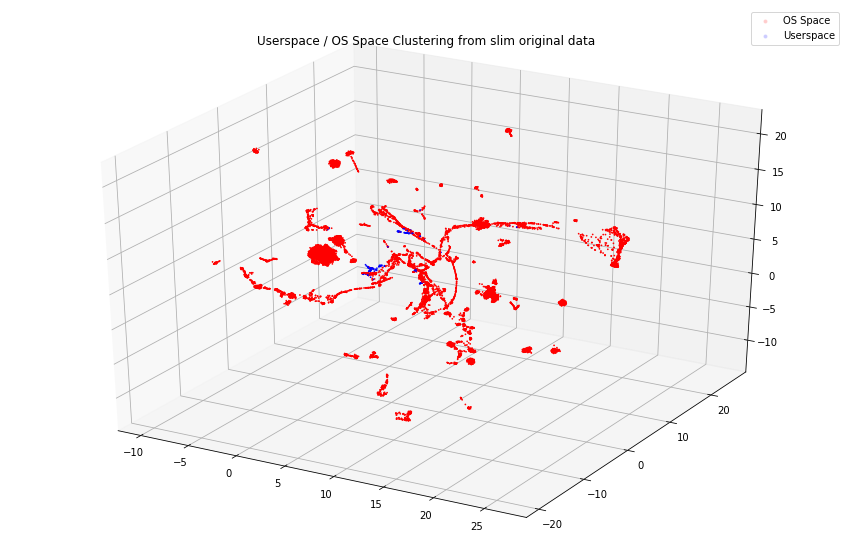

In [95]:
# UMAP on original data
draw_umap(orig_train3, colors, legend, title="Userspace / OS Space Clustering from slim original data", fig_size=2)

## Revisiting Problem 1

In [58]:
# Deeper Model
class Deep_Model(nn.Module):
    ''' A simple feed forward network model for regression '''
    def __init__(self):
        super(Deep_Model, self).__init__()

        self.relu    = nn.ReLU()
        self.linear1 = nn.Linear(n, 300)
        self.linear2 = nn.Linear(300, 300)
        self.linear3 = nn.Linear(300, 300)
        self.linear4 = nn.Linear(300, 300)
        self.linear5 = nn.Linear(300, 300)
        self.linear6 = nn.Linear(300, 300)
        self.linear7 = nn.Linear(300, 300)
        self.linear8 = nn.Linear(300, 300)
        self.linear9 = nn.Linear(300, 1)
        self.flat    = nn.Flatten()

    def forward(self, x):
        out1 = self.relu(self.linear1(x))
        out = self.relu(self.linear2(out1))
        out = self.relu(self.linear3(out))
        out = self.relu(self.linear4(out))
        out = self.relu(self.linear5(out)) + out1 # Skip connection
        out = self.relu(self.linear6(out))
        out = self.relu(self.linear7(out))
        out = self.relu(self.linear8(out))
        out = self.linear9(out)
        return self.flat(out)

In [59]:
# Test the model
# n = orig_train3.shape[1]
n = orig_train2.shape[1] # TEST WITH 2D SO WE CAN MAP THE OUTPUT WITH A GRID
model_orig = Deep_Model().to(device)
# n = embed_train3.shape[1]
# model_embed = FF_Model().to(device)

print("Parameters:", np.sum([np.prod(p.size()) for p in model_orig.parameters()]))

# m = model_orig(torch.tensor(orig_train3)[0].unsqueeze(0).to(device))
# print(m)

B = 20 # Batch Size
T = len(orig_train3) // B
E = 40 # Max epochs

Parameters: 633301


In [60]:
# Init
losses_orig = []
# losses_embed = []
loop = tqdm(total=T*E, position=0)

# Convert types and move to GPU if available
# X_orig_train  = torch.tensor(orig_train3).to(device)
# X_embed_train = torch.tensor(embed_train3).to(device)
X_orig_train = torch.tensor(orig_train2).to(device) # TEST USING 2D SO WE CAN MAP THE OUTPUT WITH A GRID
Y_train = torch.tensor(RW_train.values).to(device)

# Define our optimization scheme
objective = nn.L1Loss()
opt_o = optim.Adam(model_orig.parameters())
# opt_e = optim.Adam(model_embed.parameters())

# Train
for epoch in range(E):
    for i in range(T):
        # Slice to get a batch
        xo = X_orig_train[B*i:B*(i+1)]  # Data
        #xe = X_embed_train[B*i:B*(i+1)] # Data
        y  = Y_train[B*i:B*(i+1)]  # Labels (Truth)
        # Optimize
        opt_o.zero_grad()                   # Zero out the gradients
        #opt_e.zero_grad()
        out_o = model_orig(xo)              # Run the model
        #out_e = model_embed(xe)
        loss_o = objective(torch.flatten(out_o), y) # Calculate the loss
        #loss_e = objective(torch.flatten(out_e), y)
        losses_orig.append(loss_o.item())   # Save the loss for later
        #losses_embed.append(loss_e.item())
        loss_o.backward()                   # Backpropogate the error
        #loss_e.backward()
        opt_o.step()                        # Optimize
        #opt_e.step()
        #loop.set_description('Loss_o: {:.4f}, Loss_e: {:.4f}'.format(loss_o.item(), loss_e.item()))
        loop.set_description('Loss_o: {:.4f}'.format(loss_o.item()))
        loop.update(1)

Loss_o: 1.6566: 100%|█████████▉| 28239/28240 [07:28<00:00, 59.27it/s]  

In [88]:
# test_lo = []
# # test_le = []

# X_orig_test  = torch.tensor(orig_test3).to(device)
# X_embed_test = torch.tensor(embed_test3).to(device)
X_orig_test = torch.tensor(orig_test2).to(device)

# Validate
model_orig.eval() # Set model to evaluation mode
# model_embed.eval()
out_o = model_orig(X_orig_test) # Run the model
# out_e = model_embed(X_embed_test)
out_o  = np.ravel(out_o.detach().numpy())
# out_e  = np.ravel(out_e.detach().numpy())
dist_o = np.abs(out_o - RW_test.values)
# dist_e = np.abs(out_e - RW_test.values)
model_orig.train() # Set model back to training mode
# model_embed.train()

# test_lo = []
# test_le = []

# X_orig_test  = torch.tensor(orig_train3).to(device)
# X_embed_test = torch.tensor(embed_train3).to(device)
X_orig_test  = torch.tensor(orig_train2).to(device)

# # Validate
model_orig.eval() # Set model to evaluation mode
# model_embed.eval()
out_o = model_orig(X_orig_test) # Run the model
# out_e = model_embed(X_embed_test)
out_o  = np.ravel(out_o.detach().numpy())
# out_e  = np.ravel(out_e.detach().numpy())
dist_o_train = np.abs(out_o - RW_train.values)
# dist_e = np.abs(out_e - RW_train.values)
model_orig.train() # Set model back to training mode
# model_embed.train()

Deep_Model(
  (relu): ReLU()
  (linear1): Linear(in_features=2, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=300, bias=True)
  (linear4): Linear(in_features=300, out_features=300, bias=True)
  (linear5): Linear(in_features=300, out_features=300, bias=True)
  (linear6): Linear(in_features=300, out_features=300, bias=True)
  (linear7): Linear(in_features=300, out_features=300, bias=True)
  (linear8): Linear(in_features=300, out_features=300, bias=True)
  (linear9): Linear(in_features=300, out_features=1, bias=True)
  (flat): Flatten()
)

$\mu_i: 15.26565
Avg |W_i-\mu_i|: 14.476266
Loss_o: 5.1881022453308105
Accuracy_o: 0.641613245010376


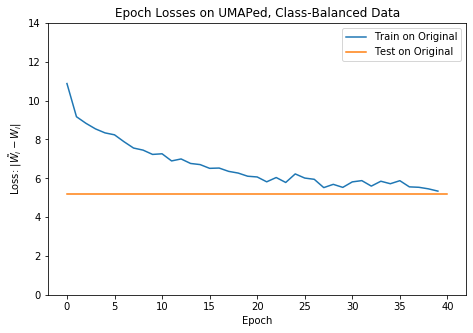

In [65]:
# Print average loss
mu = np.mean(RW_test)
# lo, le = np.mean(dist_o), np.mean(dist_e)
lo = np.mean(dist_o)
avg_dist = np.mean(np.abs(RW_test-mu))
print(r"$\mu_i:", mu)
print(r"Avg |W_i-\mu_i|:", avg_dist)
print(f"Loss_o: {lo}")#, Loss_e: {le}")
print(f"Accuracy_o: {(avg_dist-lo)/avg_dist}")#, Accuracy_e: {(avg_dist-le)/avg_dist}") 

# mu = np.mean(RW_train)
# lo, le = np.mean(dist_o), np.mean(dist_e)
# avg_dist = np.mean(np.abs(RW_train-mu))
# print(r"$\mu_i:", mu)
# print(r"Avg |W_i-\mu_i|:", avg_dist)
# print(f"Loss_o: {lo}, Loss_e: {le}")
# print(f"Accuracy_o: {(avg_dist-lo)/avg_dist}, Accuracy_e: {(avg_dist-le)/avg_dist}") 

# Compute epoch average for losses
l = int(len(losses_orig)/E)
avg_losses_orig = [np.mean(losses_orig[i*l:(i+1)*l]) for i in range(E)]
# avg_losses_embed = [np.mean(losses_embed[i*l:(i+1)*l]) for i in range(E)]

# Plots
plt.figure(figsize=(7.5,5))
plt.title("Epoch Losses on UMAPed, Class-Balanced Data")
plt.ylabel(r"Loss: $|\tilde{W_i}-W_i|$")
plt.plot(avg_losses_orig,label="Train on Original")
# plt.plot(avg_losses_embed,label="Train on Embedded Paths")
plt.plot([0,E], [lo, lo], label='Test on Original')
# plt.plot([0,E], [le, le], label="Test on Embedded Paths")
plt.xlabel("Epoch")
plt.ylim((0,14))
plt.legend()

plt.savefig("umap_losses.pdf",bbox_inches="tight")
plt.show()

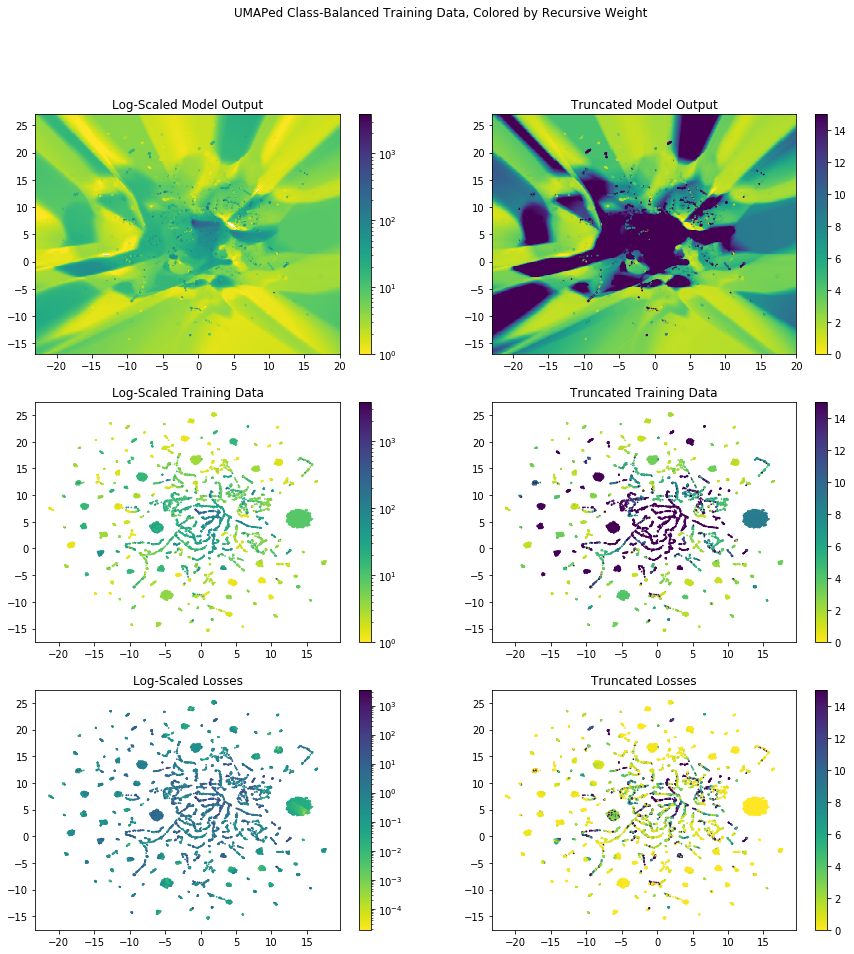

In [103]:
# generate 2 2d grids for the x & y bounds
x, y = np.meshgrid(np.linspace(-23, 20, 300), np.linspace(-17, 27, 300))

X = torch.tensor(np.array(list(zip(x.ravel(), y.ravel()))).astype(np.float32)).to(device)

# Compute with model
model_orig.eval() # Set model to evaluation mode
values = model_orig(X) # Run the model
values  = np.ravel(values.detach().numpy())
model_orig.train() # Set model back to training mode

z = values.reshape((300, 300))

# # x and y are bounds, so z should be the value *inside* those bounds.
# # Therefore, remove the last value from the z array.
# z = z[:-1, :-1]
# z_min, z_max = -np.abs(z).max(), np.abs(z).max()
vmin = max(1, min(np.amin(RW_train.values), np.amin(z)))
vmax = max(np.amax(RW_train.values), np.amax(z))


fig = plt.figure(figsize=(15,15))
plt.suptitle("UMAPed Class-Balanced Training Data, Colored by Recursive Weight")

plt.subplot(321)
c = plt.pcolormesh(x, y, z, cmap='viridis_r', norm=mc.LogNorm(), vmin=vmin, vmax=vmax)
# ax.set_adjustable('box-forced')
# ax.autoscale(False)
plt.title('Log-Scaled Model Output')
# set the limits of the plot to the limits of the data
# ax.axis([x.min(), x.max(), y.min(), y.max()])
plt.colorbar(c)

d = plt.scatter(*orig_train2.T, c=RW_train.values, s=.5, cmap='viridis_r', vmin=vmin, vmax=vmax, norm=mc.LogNorm())
# plt.colorbar(d)

plt.subplot(323)
plt.title("Log-Scaled Training Data")
d=plt.scatter(*orig_train2.T, c=RW_train.values, s=.5, cmap='viridis_r', vmin=vmin, vmax=vmax, norm=mc.LogNorm())
plt.colorbar(d)

plt.subplot(325)
plt.title("Log-Scaled Losses")
e=plt.scatter(*orig_train2.T, c=dist_o_train, s=.5, cmap='viridis_r', norm=mc.LogNorm())
plt.colorbar(e)

plt.subplot(326)
plt.title("Truncated Losses")
e=plt.scatter(*orig_train2.T, c=dist_o_train, s=.5, cmap='viridis_r', vmin=0, vmax=15)#, norm=mc.LogNorm())
plt.colorbar(e)

#

plt.subplot(322)
f = plt.pcolormesh(x, y, z, cmap='viridis_r', vmin=0, vmax=15)
# ax.set_adjustable('box-forced')
# ax.autoscale(False)
plt.title('Truncated Model Output')
# set the limits of the plot to the limits of the data
# ax.axis([x.min(), x.max(), y.min(), y.max()])
plt.colorbar(f)
plt.scatter(*orig_train2.T, c=RW_train.values, s=.5, cmap='viridis_r', vmin=0, vmax=15)

plt.subplot(324)
plt.title("Truncated Training Data")
g=plt.scatter(*orig_train2.T, c=RW_train.values, s=.5, cmap='viridis_r', vmin=0, vmax=15)
plt.colorbar(g)

plt.show()

The outputs looked so good originally because they were on a log scale, so we exponentially lose an understanding of how far off the model is as we get higher on the scale. However, with the middle-right plot we can see the non-log-scaled variance within some of the clusters, and with the bottom-right plot we can see how varied our results are when we try to treat one cluster as all the same. Likewise, in the two upper plots we can see sticking out the loners in what used to appear as strands of similar colors.

$accuracy(\tilde{W_i})=\left\{ 1 if |\tilde{W_i}-W_i| < \frac{W_i}{2} \\ 0 otherwise \right.$

In [107]:
# NEW ACCURACY METRIC
acc = lambda ratio: np.mean(dist_o_train < (ratio * RW_train.values))
for i in range(1, 11):
    print(f"{i}/10:", acc(i/10))

1/10: 0.5562632696390658
2/10: 0.7025477707006369
3/10: 0.7793347487615003
4/10: 0.821726822363765
5/10: 0.8570417551309271
6/10: 0.8870488322717622
7/10: 0.9110403397027601
8/10: 0.9370134465675867
9/10: 0.9588818117480538
10/10: 0.9735314932767162


Consider using the kernel trick and string edit distance as kernel function, then doing Support Vector Regression on the data, to see if we get cleaner representation of Recursive Weight this way! Consider also using a Random Forest on the paths or other data to create a proximity estimation, and perhaps a kernel function from that?

## Old Stuff

In [4]:
# # Partition the data into user space versus OS space
# userspace = data[data.Userspace == 1]#.drop("Userspace", axis=1) # Screws with indices if we drop it.
# osspace   = data[data.Userspace == 0]#.drop("Userspace", axis=1)
# print("Size of User Space:", len(userspace))
# print("Size of OS   Space:", len(osspace))

# # Define some constants for use later
# cols = list(data.columns)
# P = cols.index("Parent")
# D = cols.index("Is Directory")
# F = cols.index("Is Regular File")
# L = cols.index("Is Link To")
# DESK = cols.index("Desktop")
# DEPTH = cols.index("Depth")
# C = cols.index("Child Count")

Size of User Space: 72708
Size of OS   Space: 935976
